In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from common import haversine_cluster

In [2]:
df = pd.read_csv("data/mappers_processed.csv")

In [3]:
# Limit to SF Bay
lat_bounds = [37, 38]
long_bounds = [-124, -122]

df = df[df["target_lat"] > min(lat_bounds)]
df = df[df["target_lat"] < max(lat_bounds)]
df = df[df["target_long"] > min(long_bounds)]
df = df[df["target_long"] < max(long_bounds)]


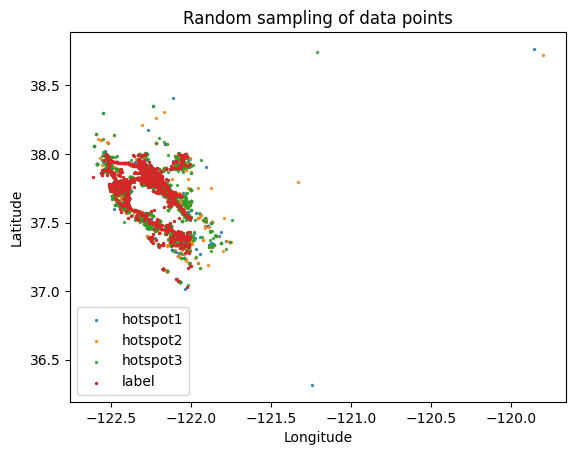

In [4]:
subset = df.sample(n=min(len(df), 5000))
for i in range(1,4):
    plt.scatter(subset[f"hotspot{i}_long"], subset[f"hotspot{i}_lat"], s=2, alpha=0.8, label=f"hotspot{i}")
plt.scatter(subset["target_long"], subset["target_lat"], s=2, label="label")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Random sampling of data points")
plt.legend()

In [5]:
data = np.concatenate([
    df[[f"{prefix}_lat", f"{prefix}_long"]].to_numpy() for prefix in ["target", "hotspot1", "hotspot2", "hotspot3"]
])
print(data.shape)

(1652092, 2)


In [6]:
# Start by dividing the lat/long area into an evenly spaced grid of clusters
n_div_lat = 100
n_div_long = 500
cluster_div_lat = np.linspace(np.min(data[:,0]), np.max(data[:,0]),  n_div_lat)
cluster_div_long = np.linspace(np.min(data[:,1]), np.max(data[:,1]),  n_div_long)
centroids = np.zeros((cluster_div_lat.shape[0]*cluster_div_long.shape[0], 2))
for i, lat in enumerate(cluster_div_lat):
    for j, long in enumerate(cluster_div_long):
        centroids[i * n_div_long + j] = [lat, long]

# Then cluster the data points to the nearest "cluster" based on haversine dist
labels = haversine_cluster(
    # use only a subset of 40000 data points... since this is expensive
    points_lat_long_deg=data[np.random.choice(data.shape[0], 40000, replace=False), :], 
    centroids_lat_long_deg=centroids,
    trace=True
)

# Remove any clusters that have no data points... 
# this reduces the final number of clusters while keeping an even spacing
populated_centroid_idxs = np.array(sorted(np.unique(labels)))
centroids = centroids[populated_centroid_idxs, :]
print(centroids.shape)

100%|██████████| 50000/50000 [01:38<00:00, 506.84it/s]


(1184, 2)


100%|██████████| 1184/1184 [00:00<00:00, 2463.26it/s]


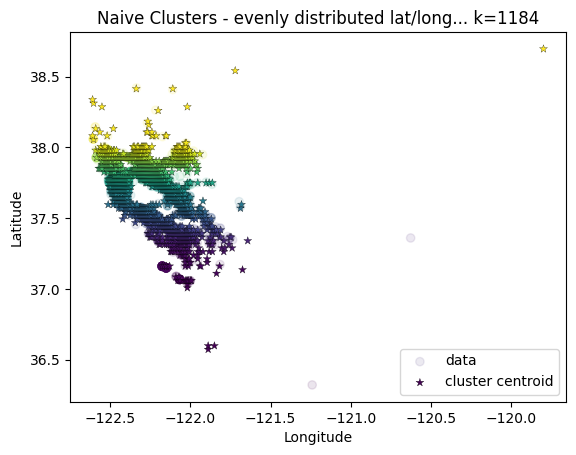

In [8]:
# Visualize clusters
sample_idxs = np.random.choice(data.shape[0], min(10000, data.shape[0]), replace=False)
samples = data[sample_idxs, :]
labels = haversine_cluster(samples, centroids, trace=True)
plt.scatter(samples[:,1], samples[:,0], alpha=0.1, c=labels, label="data")
plt.scatter(centroids[:,1], centroids[:,0], marker="*", linewidth=0.2, edgecolors='k', c=np.arange(centroids.shape[0]), label="cluster centroid")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title(f"Naive Clusters - evenly distributed lat/long... k={centroids.shape[0]}")
plt.show()

In [12]:
df_out = pd.DataFrame({"cluster_lat": centroids[:,0], "cluster_long": centroids[:,1]})
df_out.to_csv("data/clusters_sfbay.csv", index=False)